In [6]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [342]:
def lambda_initaliser(n): #bigger Lambda means smaller effective updates, more regularisation, more precise prior
#     return (np.ones((n,n))+np.eye(n))*1e1
#     return (-1*np.ones((n,n))+np.eye(n)*(n))*1
#     return (np.ones((n,n))+np.diag(np.random.rand(n))+np.random.rand(n,n)*0.1)*1
    return (np.eye(n))/n**1#/np.sqrt(n)
#     return np.ones((n,n))*1e-4

In [343]:
def initialiser_function(rows,columns):
#     return np.random.randn(rows,columns)
#     inits= np.zeros((rows,columns))+np.random.randn(rows,columns)*0.1
#     inits=(np.random.randn(rows,columns))*np.sqrt(6)/np.sqrt(rows+columns)
    inits=(np.random.randn(rows,columns))*np.sqrt(6)/np.sqrt(rows+columns)
#     inits=(np.random.randn(rows,columns))*np.sqrt(2)/np.sqrt(rows)

#     inits=(np.random.randn(rows,columns))*np.sqrt(6)/np.sqrt(rows+columns)

#     inits=(np.random.randn(rows,columns)*2)*np.sqrt(6)/np.sqrt(rows+columns)*0
#     inits=(np.random.randn(rows,columns))*0.1#*np.sqrt(6)/np.sqrt(rows+columns)
#     inits=(np.random.rand(rows,columns)*2-1)*np.sqrt(6)/np.sqrt(rows+columns)

#     inits[0,:]=np.ones((1,columns))
    return inits


In [172]:
def bias_initialiser(n):

    return (np.random.randn(1,n)*2-1)*np.sqrt(6)/np.sqrt(n+1)


In [10]:
class NNet:
    # this is a standard normal network using ReLU activation functions
    # and an identity as the output activation function
    # it is trained using standard gradient descent with gradients calculated using backprop
    
    def __init__(self,hidden_layer_sizes, input_dim, output_dim,initialiser_function=initialiser_function):
        
        self.layer_sizes=hidden_layer_sizes
        self.input_dim=input_dim
        self.output_dim=output_dim
        
        self.weights=[] #initialise weights, the bias vectors are treated as an extra row of the weights
        self.weights.append(initialiser_function(input_dim+1,hidden_layer_sizes[0]))
        for ii in range(len(hidden_layer_sizes)-1):
            self.weights.append(initialiser_function(hidden_layer_sizes[ii]+1,hidden_layer_sizes[ii+1]))
        self.weights.append(initialiser_function(hidden_layer_sizes[-1]+1,output_dim))
        
        #initialise variables calculated when using the network
        self.activated=[] 
        self.z=[]
        self.a=[]
        self.Delta=[]
        
    def forward(self,x):
        # Does a forward pass of the network, and saves relevent variables
        
        #clear saved variables for forward pass
        self.z=[]
        self.a=[]
        self.activated=[]
        
        x=np.hstack([np.ones((x.shape[0],1)),x]) #append 1 to the x to account for the bias

        for ii in range(len(self.weights)):

            x=x @ self.weights[ii]

            if not ii== len(self.weights)-1: #if not the end
                x=np.hstack([np.ones((x.shape[0],1)),x]) # append 1 to account for the bias
                self.activated.append(x>0) #save whether the neurons were activated
                self.z.append(x) 
                x=x*self.activated[ii] #apply ReLU activation function
                self.a.append(x) #save activations

                if np.sum(np.sum(self.activated[ii]))==0: #if there are no activations in a layer
                    print('No activations')
            
        self.z.append(x) #append the final things
        
        # for this case we are using the identity as the final activation function because we want to 
        # approximate functions with negative values
        # this means that the neurons in the final layer are always activated
        self.a.append(x)
        self.activated.append(np.ones(x.shape,dtype=bool))
        return x
    
    def gradients(self,x,Y):
        # calculates the gradients of neural network using standard back propagation
        
        Delta=[] #Delta=d(loss)/dz=d(loss)/da*gradsigma(z)
        
        #the self.activated variable is the effectively the grad of the activation function

        Delta.append((Y-self.a[-1])*self.activated[-1]) #calculate Delta for the final layer
        for ll in range(len(self.weights)-2,-1,-1):
            #calculate Delta for the other layers
            Delta.insert(0,((Delta[0] @ self.weights[ll+1].T)*self.activated[ll])[:,1:])
        
        grad_w=[] #calculating the gradient of the error with respect to the weights
        grad_w.append(Delta[0].T @ np.hstack([np.ones((x.shape[0],1)),x]))
        for ll in range(len(Delta)-1):
            grad_w.append(Delta[ll+1].T @ self.a[ll])
            
        return grad_w
    
    def train(self,xx,YY,alpha=0.01, print_error=False):
        #trains the neural network for one epoch, one sample at a time using standard SGD
        
        #shuffle the data
        inds=np.arange(xx.shape[0])
        np.random.shuffle(inds)
        xx=xx[inds,:]
        YY=YY[inds,:]
        
        for ii in range(len(YY)):
            # for each piece of data
            x=xx[ii,:]
            x=x.reshape((1,x.shape[0]))
            Y=YY[ii,:]
            
            Y_out=self.forward(x) #do a forward pass
            error_out=np.sum((Y-Y_out)**2) #calcuate the loss, in this case the square error
            grad_w=self.gradients(x,Y) #calculate the gradients
#             print(self.biases)
            for ll in range(len(self.weights)):
                # update the weights using the gradients
                self.weights[ll]=self.weights[ll]+alpha*grad_w[ll].T
                
            if print_error: #print the error if you want
                print(str(ii)+': Error: '+ str(error_out))
            

In [11]:
class BNet5:
    
    def __init__(self,hidden_layer_sizes, input_dim, output_dim,initialiser_function=initialiser_function,lambda_initaliser=lambda_initaliser):
        self.layer_sizes=hidden_layer_sizes
        self.input_dim=input_dim
        self.output_dim=output_dim
        self.weights=[]
        self.biases=[]
        self.Lambda=[]
        self.weights.append(initialiser_function(input_dim+1,hidden_layer_sizes[0]))
        self.Lambda.append(lambda_initaliser(input_dim+1))
        for ii in range(len(hidden_layer_sizes)-1):
            self.weights.append(initialiser_function(hidden_layer_sizes[ii]+1,hidden_layer_sizes[ii+1]))
            self.Lambda.append(lambda_initaliser(hidden_layer_sizes[ii]+1))
        self.weights.append(initialiser_function(hidden_layer_sizes[-1]+1,output_dim))
        self.Lambda.append(lambda_initaliser(hidden_layer_sizes[-1]+1))
        self.activated=[]
        self.z=[]
        self.a=[]
        self.Delta=[]
    def forward(self,x):
#         print(x.shape)
        self.z=[]
        self.a=[]
        self.activated=[]
#         assert len(x)==self.input_dim
        x=np.hstack([np.ones((x.shape[0],1)),x])
        all_activated=1
        for ii in range(len(self.weights)):

            x=x @ self.weights[ii]

#             self.activated.append(x>0)
#             self.z.append(x)
            if not ii== len(self.weights)-1:
                x=np.hstack([np.ones((x.shape[0],1)),x])
                self.activated.append(x>0)
                self.z.append(x)
                x=x*self.activated[ii]
                self.a.append(x)
#             print(x)
                if np.sum(np.sum(self.activated[ii][:,1:]))==0:
#                     print('No activations')
                    all_activated=0
        self.z.append(x)
        self.a.append(x)
        self.activated.append(np.ones(x.shape,dtype=bool))
#             print(self.activated)
        return x, all_activated
    
    
    
    def train(self,xx,YY,passes=1, print_error=False,attempt_numbers=5,total_info=1):
        c=total_info/passes
        sample_used=np.zeros(len(xx))
        for attempt in range(attempt_numbers):
            
            for ii in range(len(YY)):
                
                if not sample_used[ii]:
                    x=xx[ii]
                    x=x.reshape((1,x.shape[0]))
                    Y=YY[ii]
                    Y=Y.reshape((1,Y.shape[0]))
        #             print(Y.shape)
                    Y_out,all_activated=self.forward(x)
#                     all_activated=1
                    error_out1=np.sum((Y-Y_out)**2)
                    if all_activated:
                        sample_used[ii]=1

                        for ps in range(passes):
                            Y_out,all_activated=self.forward(x)

                            for ll in range(len(self.weights)-1,-1,-1):
            #                     print(ll)
                                xl=self.a[ll-1]
                                if ll==len(self.weights)-1:
                                    Yl=Y
                                    w=self.weights[ll]
                                else:
            #                         print(Yl.shape)
            # #                         print(np.linalg.pinv(self.weights[ll+1]).shape)
            #                         print(np.linalg.pinv(w).shape)

                                    Yl=Yl @ np.linalg.pinv(w)
                                    Yl=Yl[:,1:]/Yl[0,0] #the bias isn't an outout of the previous transformation, but we can use it to normalise
            #                         print(Yl.shape)
                                    Yl=Yl[:,self.activated[ll][0,1:]]
                                    w=self.weights[ll][:,self.activated[ll][0,1:]] #this constructs a new weight mat using only the columns that lead to activations
                                L=self.Lambda[ll]

            #                     print(xl.T.shape)
            #                     print(Yl.shape)
            #                     print(L.shape)
            #                     print(w.shape)
            #                     print(w)
            #                     print(w.shape)
            #                     print(Yl.shape)

            #                     print(xl.shape)
            #                     print(w.shape)
            #                     print(np.linalg.inv(c*(xl.T @ xl) + L).shape)
            #                     print(((xl.T @ Yl)).shape)
            #                     print(L.shape)
                                w=np.linalg.pinv(c*(xl.T @ xl) + L) @ (c*(xl.T @ Yl) + L @ w)
            #                     print(w)
                                w=np.nan_to_num(w)
                                L=c*xl.T @ xl + L
                                if ll==len(self.weights)-1:
                                    self.weights[ll]=w
                                else:
                                    self.weights[ll][:,self.activated[ll][0,1:]]=w
                                self.Lambda[ll]=L
            #                     print(self.weights[ll])
                    else:
                        print('not today')
                    Y_out,all_activated=self.forward(x)

                    error_out2=np.sum((Y-Y_out)**2)

                    if print_error:
                        print(str(ii)+': Error1: '+ str(error_out1)+', Error2: '+ str(error_out2))
            print(sum(sample_used))

In [84]:
def find_Y(Y,w1,X0): 
    # This function finds the new Y value for the layer, by going 'backwards' through the matrix
    # initally we had X0 @ w0 = Y, and then updated w0 -> w1, so now we solve X1 @ w1 = Y for X1
    # this is often under determined, and so we find the X1 which is closest (L2 norm) to X0

    delta=w1 @ np.linalg.inv(w1.T @ w1) @ (Y - X0 @ w1).T
    X1 = X0+delta.T

    # remember to kill bias if needed
    return X1

In [85]:
class BNet6:
    # Neural net that can be trained using approximate (dodgy) Bayesian updating
    # The forward pass works just like a standard neural net
    # For training this one does all the passes for one sample in a row, rather than running through all the data
    
    def __init__(self,hidden_layer_sizes, input_dim, output_dim,initialiser_function=initialiser_function,lambda_initaliser=lambda_initaliser):
        self.layer_sizes=hidden_layer_sizes
        self.input_dim=input_dim
        self.output_dim=output_dim
        
        # initalise the weights and Lambda matrices
        # the weights are the standard weights of the network
        # the Lambda matrices are the (inverse of) the covariance matrices of the rows of the weight matrices
        # the Lambdas are a measure of the 'precision' of each weight matrix
        # we do not consider any effect of covariance between different layers (that's a task for another day...)
        self.weights=[]
        self.Lambda=[]
        self.weights.append(initialiser_function(input_dim+1,hidden_layer_sizes[0]))
        self.Lambda.append(lambda_initaliser(input_dim+1))
        for ii in range(len(hidden_layer_sizes)-1):
            self.weights.append(initialiser_function(hidden_layer_sizes[ii]+1,hidden_layer_sizes[ii+1]))
            self.Lambda.append(lambda_initaliser(hidden_layer_sizes[ii]+1))
        self.weights.append(initialiser_function(hidden_layer_sizes[-1]+1,output_dim))
        self.Lambda.append(lambda_initaliser(hidden_layer_sizes[-1]+1))
        
        #initialise variables calculated when using the network
        self.activated=[]
        self.z=[]
        self.a=[]
        self.Delta=[]
    def forward(self,x):
        #performs a standard forward pass of the network, saving relevant variables
        
        self.z=[]
        self.a=[]
        self.activated=[]
        x=np.hstack([np.ones((x.shape[0],1)),x]) #append 1 to account for bias
        all_activated=1 #keep to make sure there is at least one activation in each layer
        # if there are no activations in a layer then you can't do the back step
        # Not sure if the bias should count towards the activation (I don't think so)
        
        for ii in range(len(self.weights)):

            x=x @ self.weights[ii] #apply weight matrix

            if not ii== len(self.weights)-1: # if it's not the final layer
                
                x=np.hstack([np.ones((x.shape[0],1)),x]) #append the 1 for the bias
                self.activated.append(x>0) #which neurons are activated
                self.z.append(x)
                x=x*self.activated[ii] #apply the ReLU
                self.a.append(x) #save activations
#             print(x)
                if np.sum(np.sum(self.activated[ii][:,1:]))==0: #test if there was at least on activation in each layer
#                     print('No activations')
                    all_activated=0
        #saving variables for the last layer
        #for this output layer we are using just the identity as the activation function (not a non linear function)
        # this can be thought of as a ReLU that is always activated
        self.z.append(x)
        self.a.append(x)
        self.activated.append(np.ones(x.shape,dtype=bool))
        return x, all_activated
    
    
    
    def train(self,xx,YY,passes=1, print_error=False,failed_attempts=5,total_info=1):
        # trains the network using 'Bayes'
        # xx is the input data, YY measured variable corresponding to xx
        # passes is the number of times you go over the data
        # total_info is the total amount of 'information' transfered over all the passes
        # print_error if you want to print the error each time
        # failed_attempts is how many times to try use the same piece of data if each time it
        # means that there are no neurons in a layer and thus can't be used to train
        
        #shuffle the data
        inds=np.arange(xx.shape[0])
        np.random.shuffle(inds)
        xx=xx[inds,:]
        YY=YY[inds,:]
        
        c=total_info/passes #this is analogous to alpha in SGD
        sample_used=np.zeros(len(xx)) # number of times the sample has been used, corresponds to 'passes'
        sample_attempted= np.zeros(len(xx)) # number of times the sample has been attempted and failed, corresponds to 'failed_attempts'
        
        
        still_going= True # keeps going if we haven't had the right number of passes or failed attempts
        
        while still_going:
            
            for ii in range(len(YY)): #for each sample

                if sample_used[ii]<passes: #if this data hasn't already been used too many times
                    x=xx[ii,:]
                    x=x.reshape((1,x.shape[0]))                    
                    Y=YY[ii,:]
                    Y=Y.reshape((1,Y.shape[0]))

                    Y_out,all_activated=self.forward(x) #do a forward pass
                    # Y_out is just used for printing the error
                    # all_activated = 1 if all layers have at least one activated neuron
    #                     all_activated=1
                    
                    error_out1=np.sum((Y-Y_out)**2) #calculate MSE
                    if all_activated:
                        sample_used[ii]+=1 #count the times this sample has been used

                        for ps in range(passes):
                            Y_out,all_activated=self.forward(x) #do a forward pass each time to calculate new values of self.a etc

                            for ll in range(len(self.weights)-1,-1,-1):
                                #updating the weight matrices, starting from the final one

                                xl=self.a[ll-1] #set xl to the 'input' of the weight matrix
                                
                                if ll==len(self.weights)-1: 
                                    # if we are updating the final weight matrix (which we do first)
                                    # then set Yl to the actual value of Y, and w to the weight matrix
                                    Yl=Y
                                    w=self.weights[ll] #this is a tempory variable for the weights which get updated
                                    # because we are using the identity as the final acivation function 
                                    # this is just the weight matrix, we don't need to modify it
                                else:

                                    # various options for doing the 'inversion' step
                                    # can simply pseudoinvert the weights, and the normalise to the bias
#                                     Yl=Yl @ np.linalg.pinv(w)
#                                     Yl=Yl[:,1:]/Yl[0,0] #the bias isn't an outout of the previous transformation, but we can use it to normalise
                                    
                                    # can use our fancy invert method to find the closest Yl to a_l
                                    # here we just entirely leave out the bias
#                                     Yl=find_Y(Yl,w[1:,:],self.a[ll][:,1:])
                                    
                                    # or can use our fancy method, but include the bias and normalise to it
                                    Yl= find_Y(Yl, w, self.a[ll])
                                    Yl=Yl[:,1:]/Yl[0,0]
                                    
                                    # I think there may be a better way to do this, which *forces* the first element of
                                    # Yl to be one (which we would then remove)
                                    # and makes the rest of Yl as close to a_l as possible
                                
    
                                    Yl=Yl[:,self.activated[ll][0,1:]] # select only the elements of Yl which correspond to activations
                
                                    w=self.weights[ll][:,self.activated[ll][0,1:]] #this constructs a new weight mat using only the columns that lead to activations
                
                
                                L=self.Lambda[ll] # make a tempory variable for Lambda 
                                
                                # now we have the actual updating!
                                # update the weight matrix
                                w=np.linalg.inv(c*(xl.T @ xl) + L) @ (c*(xl.T @ Yl) + L @ w)
                                
#                                 w=np.nan_to_num(w)
                                # update the Lambda
                                L=c*xl.T @ xl + L
#                                 L=L*np.eye(L.shape[0])

                                if ll==len(self.weights)-1: #if updating the final layer, just set it equal to w
                                    self.weights[ll]=w
                                else: #otherwise just update the elements which were updated
                                    self.weights[ll][:,self.activated[ll][0,1:]]=w
                                self.Lambda[ll]=L # set Lambda to the new Lambda
                            
                    else: # if it failed because there were no activations
#                         print('not today')
                        sample_attempted[ii]+=1 # count fails for this sample
                    Y_out,all_activated=self.forward(x) # do another forward pass to see how the error changes

                    error_out2=np.sum((Y-Y_out)**2) # calculate the new error

                    if print_error:
                        print(str(ii)+': Error1: '+ str(error_out1)+', Error2: '+ str(error_out2)
                              +' \nTotal fails (no activations): ' +str(int(sum(sample_attempted))), end="\n\r", flush=True)

            if all([(sample_used[jj]>=passes or sample_attempted[jj]>= failed_attempts) for jj in range(len(YY))]):
                # if for each sample, it has either been used the correct number of times
                # or been attempted and failed the max number of times 
                # then end the training process
                still_going=False

In [255]:
class BNet7:
    # Neural net that can be trained using approximate (dodgy) Bayesian updating
    # The forward pass works just like a standard neural net
    
    def __init__(self,hidden_layer_sizes, input_dim, output_dim,initialiser_function=initialiser_function,lambda_initaliser=lambda_initaliser):
        self.layer_sizes=hidden_layer_sizes
        self.input_dim=input_dim
        self.output_dim=output_dim
        
        # initalise the weights and Lambda matrices
        # the weights are the standard weights of the network
        # the Lambda matrices are the (inverse of) the covariance matrices of the rows of the weight matrices
        # the Lambdas are a measure of the 'precision' of each weight matrix
        # we do not consider any effect of covariance between different layers (that's a task for another day...)
        self.weights=[]
        self.Lambda=[]
        self.weights.append(initialiser_function(input_dim+1,hidden_layer_sizes[0]))
        self.Lambda.append(lambda_initaliser(input_dim+1))
        for ii in range(len(hidden_layer_sizes)-1):
            self.weights.append(initialiser_function(hidden_layer_sizes[ii]+1,hidden_layer_sizes[ii+1]))
            self.Lambda.append(lambda_initaliser(hidden_layer_sizes[ii]+1))
        self.weights.append(initialiser_function(hidden_layer_sizes[-1]+1,output_dim))
        self.Lambda.append(lambda_initaliser(hidden_layer_sizes[-1]+1))
        
        #initialise variables calculated when using the network
        self.activated=[]
        self.z=[]
        self.a=[]
        self.Delta=[]
    def forward(self,x):
        #performs a standard forward pass of the network, saving relevant variables
        
        self.z=[]
        self.a=[]
        self.activated=[]
        x=np.hstack([np.ones((x.shape[0],1)),x]) #append 1 to account for bias
        all_activated=1 #keep to make sure there is at least one activation in each layer
        # if there are no activations in a layer then you can't do the back step
        # Not sure if the bias should count towards the activation (I don't think so)
        
        for ii in range(len(self.weights)):

            x=x @ self.weights[ii] #apply weight matrix

            if not ii== len(self.weights)-1: # if it's not the final layer
                
                x=np.hstack([np.ones((x.shape[0],1)),x]) #append the 1 for the bias
                self.activated.append(x>0) #which neurons are activated
                self.z.append(x)
                x=x*self.activated[ii] #apply the ReLU
                self.a.append(x) #save activations
#             print(x)
                if np.sum(np.sum(self.activated[ii][:,1:]))==0: #test if there was at least on activation in each layer
#                     print('No activations')
                    all_activated=0
        #saving variables for the last layer
        #for this output layer we are using just the identity as the activation function (not a non linear function)
        # this can be thought of as a ReLU that is always activated
        self.z.append(x)
        self.a.append(x)
        self.activated.append(np.ones(x.shape,dtype=bool))
        return x, all_activated
    
    
    
    def train(self,xx,YY,passes=1, print_error=False,return_error=False,failed_attempts=5,total_info=1):
        # trains the network using 'Bayes'
        # xx is the input data, YY measured variable corresponding to xx
        # passes is the number of times you go over the data
        # total_info is the total amount of 'information' transfered over all the passes
        # print_error if you want to print the error each time
        # failed_attempts is how many times to try use the same piece of data if each time it
        # means that there are no neurons in a layer and thus can't be used to train
        
        if return_error:
            error1=[] # error1 is the error on the sample, before updating
            error2=[] # error2 is the error on the sample, after updating
        
        #shuffle the data
        inds=np.arange(xx.shape[0])
        np.random.shuffle(inds)
        xx=xx[inds,:]
        YY=YY[inds,:]
        
        c=total_info/passes #this is analogous to alpha in SGD
        sample_used=np.zeros(len(xx)) # number of times the sample has been used, corresponds to 'passes'
        sample_attempted= np.zeros(len(xx)) # number of times the sample has been attempted and failed, corresponds to 'failed_attempts'
        
        
        still_going= True # keeps going if we haven't had the right number of passes or failed attempts
        
        while still_going:
            
            for ii in range(len(YY)): #for each sample
                if sample_used[ii]<passes and sample_attempted[ii]< failed_attempts: #if this data hasn't already been used too many times
                    x=xx[ii,:]
                    x=x.reshape((1,x.shape[0]))                    
                    Y=YY[ii,:]
                    Y=Y.reshape((1,Y.shape[0]))

                    Y_out,all_activated=self.forward(x) #do a forward pass
                    # Y_out is just used for printing the error
                    # all_activated = 1 if all layers have at least one activated neuron
    #                     all_activated=1
                    
                    error_out1=np.sum((Y-Y_out)**2) #calculate MSE
                    if all_activated:
                        sample_used[ii]+=1 #count the times this sample has been used

#                         Y_out,all_activated=self.forward(x) #do a forward pass each time to calculate new values of self.a etc

                        for ll in range(len(self.weights)-1,-1,-1):
                            #updating the weight matrices, starting from the final one
                            
                            if ll==0:
                                xl=np.hstack([np.ones((x.shape[0],1)),x])
                            else:
                                xl=self.a[ll-1] #set xl to the 'input' of the weight matrix

                            if ll==len(self.weights)-1: 
                                # if we are updating the final weight matrix (which we do first)
                                # then set Yl to the actual value of Y, and w to the weight matrix
                                Yl=Y
                                w=self.weights[ll] #this is a tempory variable for the weights which get updated
                                # because we are using the identity as the final acivation function 
                                # this is just the weight matrix, we don't need to modify it
                            else:

                                # various options for doing the 'inversion' step
                                # can simply pseudoinvert the weights, and the normalise to the bias
#                                     Yl=Yl @ np.linalg.pinv(w)
#                                     Yl=Yl[:,1:]/Yl[0,0] #the bias isn't an outout of the previous transformation, but we can use it to normalise

                                # can use our fancy invert method to find the closest Yl to a_l
                                # here we just entirely leave out the bias
#                                     Yl=find_Y(Yl,w[1:,:],self.a[ll][:,1:])

                                # or can use our fancy method, but include the bias and normalise to it
                                Yl= find_Y(Yl, w, self.a[ll])
                                Yl=Yl[:,1:]/Yl[0,0]

                                # I think there may be a better way to do this, which *forces* the first element of
                                # Yl to be one (which we would then remove)
                                # and makes the rest of Yl as close to a_l as possible


                                Yl=Yl[:,self.activated[ll][0,1:]] # select only the elements of Yl which correspond to activations

                                w=self.weights[ll][:,self.activated[ll][0,1:]] #this constructs a new weight mat using only the columns that lead to activations


                            L=self.Lambda[ll] # make a tempory variable for Lambda 

                            # now we have the actual updating!
                            # update the weight matrix

                            w=np.linalg.inv(c*(xl.T @ xl) + L) @ (c*(xl.T @ Yl) + L @ w)

#                                 w=np.nan_to_num(w)
                            # update the Lambda
                            L=c*xl.T @ xl + L
#                                 L=L*np.eye(L.shape[0])

                            if ll==len(self.weights)-1: #if updating the final layer, just set it equal to w
                                self.weights[ll]=w
                            else: #otherwise just update the elements which were updated
                                self.weights[ll][:,self.activated[ll][0,1:]]=w
                            self.Lambda[ll]=L # set Lambda to the new Lambda
                            
                        Y_out,all_activated=self.forward(x) # do another forward pass to see how the error changes
                        error_out2=np.sum((Y-Y_out)**2) # calculate the new error
                        if return_error:
                            error1.append(error_out1)
                            error2.append(error_out2)
                    else: # if it failed because there were no activations
#                         print('not today')
                        sample_attempted[ii]+=1 # count fails for this sample


                    if print_error:
                        print(str(ii)+': Error1: '+ str(error_out1)+', Error2: '+ str(error_out2)
                              +' \nTotal fails (no activations): ' +str(int(sum(sample_attempted))), end="\n\r", flush=True)

            if all([(sample_used[jj]>=passes or sample_attempted[jj]>= failed_attempts) for jj in range(len(YY))]):
                # if for each sample, it has either been used the correct number of times
                # or been attempted and failed the max number of times 
                # then end the training process
                still_going=False
        if return_error:
            return error1, error2

0: Error1: 2.898126710136263, Error2: 2.1784634023220894e-06 
Total fails (no activations): 0
1: Error1: 0.5910171365321435, Error2: 0.00024891058290945223 
Total fails (no activations): 0
2: Error1: 0.04891435182300399, Error2: 0.004561612631070931 
Total fails (no activations): 0
3: Error1: 0.020090952608358227, Error2: 0.00040660382896136603 
Total fails (no activations): 0
4: Error1: 0.03858116864140366, Error2: 9.470089700932067e-05 
Total fails (no activations): 0
5: Error1: 1.6263678261707515, Error2: 0.011095116901283633 
Total fails (no activations): 0
6: Error1: 0.009163741198307436, Error2: 0.0012037194792417515 
Total fails (no activations): 0
7: Error1: 0.04900357302503612, Error2: 0.011008942682508942 
Total fails (no activations): 0
8: Error1: 0.0011467125544335243, Error2: 0.0001116721194333622 
Total fails (no activations): 0
9: Error1: 0.38969113488605917, Error2: 0.0015663065604769437 
Total fails (no activations): 0
10: Error1: 0.14700010208642628, Error2: 0.0109612

86: Error1: 0.06662327512115596, Error2: 0.027075731909018373 
Total fails (no activations): 0
87: Error1: 0.01079877282091641, Error2: 0.007118803536294816 
Total fails (no activations): 0
88: Error1: 0.1093691768586404, Error2: 0.08260165777393774 
Total fails (no activations): 0
89: Error1: 0.001158994467566464, Error2: 0.0008061659762450228 
Total fails (no activations): 0
90: Error1: 0.0022868670030285637, Error2: 0.001624270682166165 
Total fails (no activations): 0
91: Error1: 0.034196075711972494, Error2: 0.025569514303234123 
Total fails (no activations): 0
92: Error1: 0.02425504138963155, Error2: 0.018025646380443076 
Total fails (no activations): 0
93: Error1: 0.01389277953169497, Error2: 0.010141237477872423 
Total fails (no activations): 0
94: Error1: 0.009206385776192273, Error2: 0.007186211040604273 
Total fails (no activations): 0
95: Error1: 0.08660316673027808, Error2: 0.055194763531018015 
Total fails (no activations): 0
96: Error1: 0.013358894298410865, Error2: 0.00

71: Error1: 6.101680683268724e-05, Error2: 3.793142077480511e-05 
Total fails (no activations): 0
72: Error1: 0.03058432140429534, Error2: 0.020230335287673335 
Total fails (no activations): 0
73: Error1: 0.006633137664559315, Error2: 0.003605023049333188 
Total fails (no activations): 0
74: Error1: 0.0006178730288026363, Error2: 0.00024848983363758936 
Total fails (no activations): 0
75: Error1: 0.024860192481300177, Error2: 0.013929054277910032 
Total fails (no activations): 0
76: Error1: 0.007672297355209604, Error2: 0.00346229150528348 
Total fails (no activations): 0
77: Error1: 1.1367493794453375e-05, Error2: 6.653830999607892e-06 
Total fails (no activations): 0
78: Error1: 0.0037987933564247412, Error2: 0.0016716139340795268 
Total fails (no activations): 0
79: Error1: 0.018555968118886476, Error2: 0.00820570877812052 
Total fails (no activations): 0
80: Error1: 1.592621687616608e-05, Error2: 9.588638174159148e-06 
Total fails (no activations): 0
81: Error1: 0.00132420718589774

56: Error1: 0.016770146818783683, Error2: 0.008972774220867705 
Total fails (no activations): 0
57: Error1: 0.018471305292177755, Error2: 0.010748550547260856 
Total fails (no activations): 0
58: Error1: 0.0021084155840294934, Error2: 0.0015279201511867596 
Total fails (no activations): 0
59: Error1: 0.009225904316341856, Error2: 0.003852470917171681 
Total fails (no activations): 0
60: Error1: 0.046326934125230104, Error2: 0.027702816678313886 
Total fails (no activations): 0
61: Error1: 6.664656431191932e-05, Error2: 3.609920184190104e-05 
Total fails (no activations): 0
62: Error1: 0.0037419120900460444, Error2: 0.0027461980214545548 
Total fails (no activations): 0
63: Error1: 0.0008861179202946403, Error2: 0.0005498253346838857 
Total fails (no activations): 0
64: Error1: 1.0208238491213195e-06, Error2: 6.323719856785194e-07 
Total fails (no activations): 0
65: Error1: 5.5174069282664635e-06, Error2: 3.538684410464014e-06 
Total fails (no activations): 0
66: Error1: 0.014496627698

41: Error1: 0.006359463175224315, Error2: 0.003182308368920002 
Total fails (no activations): 0
42: Error1: 0.0027962967495125286, Error2: 0.001635922287387599 
Total fails (no activations): 0
43: Error1: 0.06423854978735366, Error2: 0.03451026297771372 
Total fails (no activations): 0
44: Error1: 0.0027779865822850055, Error2: 0.0016982591448960107 
Total fails (no activations): 0
45: Error1: 0.6484335215163922, Error2: 0.068973030019055 
Total fails (no activations): 0
46: Error1: 0.019137777612802425, Error2: 0.010321341442985492 
Total fails (no activations): 0
47: Error1: 0.015174698285352945, Error2: 0.00925798946806674 
Total fails (no activations): 0
48: Error1: 0.0019302222733494155, Error2: 0.0011465144617152537 
Total fails (no activations): 0
49: Error1: 0.00013678580826804434, Error2: 4.7100405696064416e-05 
Total fails (no activations): 0
50: Error1: 0.026435392551777313, Error2: 0.008649124006842517 
Total fails (no activations): 0
51: Error1: 0.013979754366573578, Error

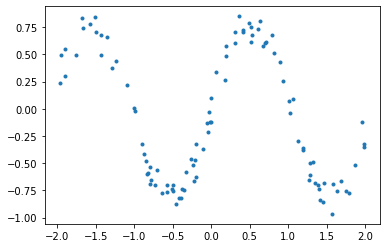

In [321]:

n_data=101
# hidden_layers=[16,32,256,32,16]
hidden_layer_options=[[16,16,16,16],[128,128,128],[256],[16,32,128,32,16]]
# hidden_layers=[128,128,128]
# hidden_layers=[16,32,128,32,16]
x=np.random.rand(n_data,1)*4-2
y= 0.8*np.sin(x*3)+np.random.randn(x.shape[0],x.shape[1])*0.1
x_test=np.linspace(-2,2,1000).reshape(1000,1)
plt.plot(x,y,'.')
y_test=[]
for ii in range(len(hidden_layer_options)):
    hidden_layers=hidden_layer_options[ii]
    net=BNet7(hidden_layer_sizes=hidden_layers,input_dim=1,output_dim=1,lambda_initaliser=lambda_initaliser,initialiser_function=initialiser_function)
    net.train(x,y,print_error=False,passes=1,total_info=1,failed_attempts=10)
    y_test.append(net.forward(x_test)[0])

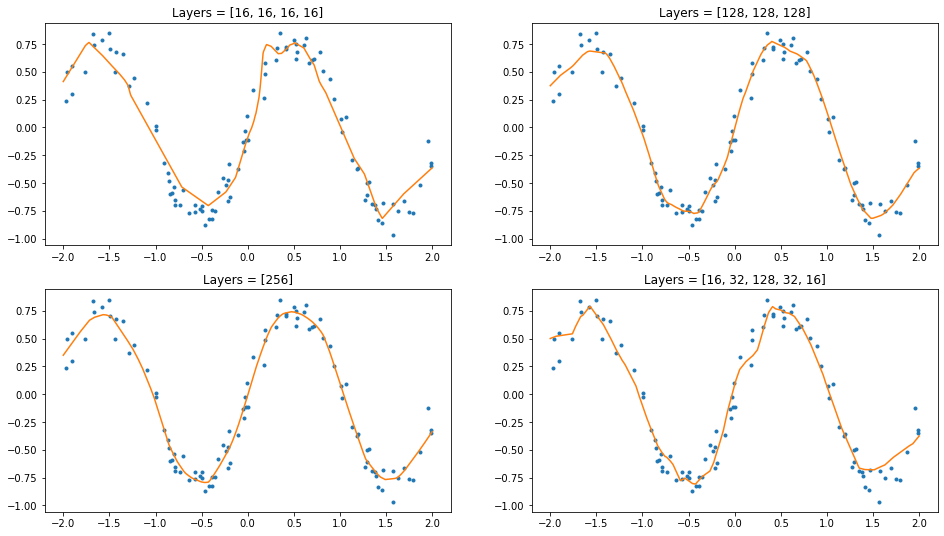

In [322]:
fig=plt.figure(figsize=(16,9))
for ii in range(4):
    fig.add_subplot(2,2,ii+1)
    plt.plot(x,y,'.')
    plt.plot(x_test,y_test[ii])
    plt.title('Layers = ' +str(hidden_layer_options[ii]))

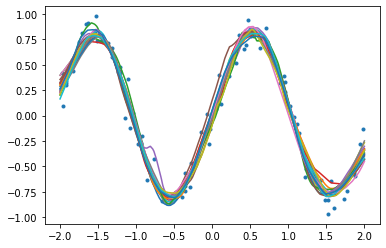

In [274]:

n_data=101
hidden_layers=[128,128,256,128]
x=np.random.rand(n_data,1)*4-2
y= 0.8*np.sin(x*3)+np.random.randn(x.shape[0],x.shape[1])*0.1
x_test=np.linspace(-2,2,1000).reshape(1000,1)
plt.plot(x,y,'.')
for ii in range(20):
    net=BNet7(hidden_layer_sizes=hidden_layers,input_dim=1,output_dim=1,lambda_initaliser=lambda_initaliser,initialiser_function=initialiser_function)
    e1,e2=net.train(x,y,print_error=False,return_error=True, passes=1,total_info=1,failed_attempts=10)
    plt.plot(x_test,net.forward(x_test)[0])

In [31]:
def test_fun_2d(x):
    # used for testing 2D data, generates the value of a radial cosine at (x[0],x[1]) for all the x
    y=0.8*np.cos(np.sqrt(x[:,0]**2+x[:,1]**2)*5)
    y=y.reshape((y.shape[0],1))+np.random.randn(y.shape[0],1)*0.1

    return y

In [62]:
def test_fun_classification(n):
    # super basic classification test
    # for n samples, generates a random 0 or 1 for y, 
    # if y=0, then x= [1,1,0,0], if y=1 then x=[0,0,1,1]
    # there is some noise added to the x
    # returns x, a one-hot vector for y, and y
    
    y=np.random.randint(2,size=(n,1))
    x=np.zeros((n,4))
    y_hot=np.zeros((n,2))
    for ii,yi in enumerate(y):
        
        if yi==0:
            y_hot[ii,0]=1
            x[ii,:]=np.array([1,1,0,0])+np.random.randn(4)*0.01
        elif yi==1:
            y_hot[ii,1]=1
            x[ii,:]=np.array([0,0,1,1])+np.random.randn(4)*0.01

        else:
            print('SOMETHING BAD')
    return x, y_hot, y

In [447]:

n_data=1001
# hidden_layers=[16,32,256,32,16]
hidden_layers=[16,16,16,16]
hidden_layers=[128,128,128]
hidden_layers=[32,256,256,32]
hidden_layers=[128,256,256,128]


n1=int(np.sqrt(n_data))

#for making x data in a grid
x1,x2=np.meshgrid(np.linspace(-2,2,n1),np.linspace(-2,2,n1))
x=np.hstack([x1.reshape((n1*n1,1)),x2.reshape(n1*n1,1)])

#for x just random sampled points
x=np.random.rand(n_data,2)*4-2

y=test_fun_2d(x) #generate y values
x_test=np.linspace(-2,2,1000).reshape(1000,1)

for ii in range(1):
    net=BNet7(hidden_layer_sizes=hidden_layers,input_dim=2,output_dim=1,lambda_initaliser=lambda_initaliser,initialiser_function=initialiser_function)
    net.train(x,y,print_error=False,passes=1,total_info=1,failed_attempts=10)


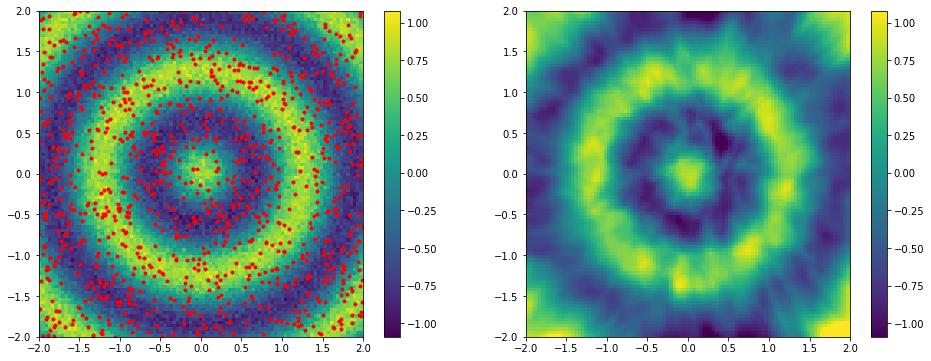

In [360]:
n1=100
x_test1,x_test2=np.meshgrid(np.linspace(-2,2,n1),np.linspace(-2,2,n1))
x_test_2d=np.hstack([x_test1.reshape((n1*n1,1)),x_test2.reshape(n1*n1,1)])
y_test_net_2d=net.forward(x_test_2d)[0].reshape((n1,n1))
y_test_2d=test_fun_2d(x_test_2d)
y_test_2d=y_test_2d.reshape((n1,n1))
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.pcolor(x_test1,x_test2,y_test_2d);
cb1=plt.colorbar()
plt.plot(x[:,0],x[:,1],'r.')
plt.subplot(1,2,2)
plt.pcolor(x_test1,x_test2,y_test_net_2d);
cb2=plt.colorbar()
plt.clim((cb1.vmin,cb1.vmax))




In [188]:
# super basic test to see if classification works at all
n_data=31
# hidden_layers=[16,32,256,32,16]
hidden_layers=[16,16,16,16]
hidden_layers=[128,128,128]
hidden_layers=[32,256,256,32]
hidden_layers=[32,128,128,32]
hidden_layers=[32,32]

x,y_hot,y=test_fun_classification(n_data) # generate data

for ii in range(1):
    net=BNet7(hidden_layer_sizes=hidden_layers,input_dim=4,output_dim=2,lambda_initaliser=lambda_initaliser,initialiser_function=initialiser_function)
    net.train(x,y_hot,print_error=False,passes=5,total_info=1,failed_attempts=10)

0: Error1: 3.4421218475142927, Error2: 3.348819010757426e-05 
Total fails (no activations): 0
1: Error1: 0.00012333791877671752, Error2: 1.4626336580925918e-05 
Total fails (no activations): 0
2: Error1: 4.901029892289976e-06, Error2: 1.1168173471728394e-06 
Total fails (no activations): 0
3: Error1: 0.002557879535037038, Error2: 0.000952926937344474 
Total fails (no activations): 0
4: Error1: 2.1229774083702475, Error2: 0.00018138310319167672 
Total fails (no activations): 0
5: Error1: 0.0003957342373864747, Error2: 5.6255527057411125e-05 
Total fails (no activations): 0
6: Error1: 5.873351312693016e-05, Error2: 1.6985435170218807e-05 
Total fails (no activations): 0
7: Error1: 6.735964781093448e-05, Error2: 2.9905313821998084e-05 
Total fails (no activations): 0
8: Error1: 5.3802601466703256e-05, Error2: 2.408867622280767e-05 
Total fails (no activations): 0
9: Error1: 0.0003454412190647298, Error2: 0.00018164639044488317 
Total fails (no activations): 0
10: Error1: 4.736224069425623

22: Error1: 0.0001145984454533882, Error2: 0.00010472054829866403 
Total fails (no activations): 0
23: Error1: 5.829235452027222e-05, Error2: 5.3790444573719254e-05 
Total fails (no activations): 0
24: Error1: 8.682646975805518e-05, Error2: 7.894613877656951e-05 
Total fails (no activations): 0
25: Error1: 2.7162422827165304e-05, Error2: 2.4503845518230438e-05 
Total fails (no activations): 0
26: Error1: 1.6606075019049366e-05, Error2: 1.5515063897670046e-05 
Total fails (no activations): 0
27: Error1: 1.0231985520219937e-05, Error2: 9.519224859858179e-06 
Total fails (no activations): 0
28: Error1: 0.0002998689615537803, Error2: 0.00027544140708440435 
Total fails (no activations): 0
29: Error1: 0.0001287424574105177, Error2: 0.00011851917886285441 
Total fails (no activations): 0
30: Error1: 3.071026730760571e-05, Error2: 2.795516829173024e-05 
Total fails (no activations): 0
0: Error1: 7.271963891148595e-05, Error2: 6.748983919787207e-05 
Total fails (no activations): 0
1: Error1: 0

In [140]:
#testing whether classification worked

n_test=10
x_test,y_hot_test,y_test=test_fun_classification(n_test) #generating test data

for ii in range(len(x_test)):
    print(y_hot[ii,:])
    print(net.forward(x[ii,:].reshape((1,4))))
    print('===')

[0. 1.]
(array([[0.00117781, 0.9988288 ]]), 1)
===
[0. 1.]
(array([[6.38600930e-04, 9.99367978e-01]]), 1)
===
[1. 0.]
(array([[ 1.00417855, -0.0041773 ]]), 1)
===
[1. 0.]
(array([[0.99729977, 0.00270164]]), 1)
===
[0. 1.]
(array([[0.00145825, 0.99854857]]), 1)
===
[1. 0.]
(array([[9.99958554e-01, 4.42586284e-05]]), 1)
===
[0. 1.]
(array([[0.00203825, 0.99796972]]), 1)
===
[0. 1.]
(array([[-0.00149771,  1.00150125]]), 1)
===
[1. 0.]
(array([[ 1.0059914 , -0.00599068]]), 1)
===
[1. 0.]
(array([[0.99348151, 0.00652134]]), 1)
===


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


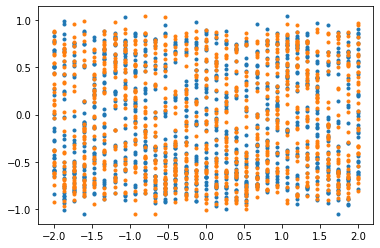

In [146]:
# sanity check some things with a standard Neural net


n_data=1001
hidden_layers=[16,16,16,16]
# hidden_layers=[64,128,128,64]
hidden_layers=[32,32,32,32]
n1=int(np.sqrt(n_data))
x1,x2=np.meshgrid(np.linspace(-2,2,n1),np.linspace(-2,2,n1))
x=np.hstack([x1.reshape((n1*n1,1)),x2.reshape(n1*n1,1)])
# x=np.random.rand(n_data,2)*4-2

y=test_fun_2d(x)
x_test=np.linspace(-2,2,1000).reshape(1000,1)
nnet=NNet(hidden_layer_sizes=hidden_layers,input_dim=2,output_dim=1,initialiser_function=initialiser_function2)

for ii in range(50):
    nnet.train(x,y,print_error=False,alpha=0.01)


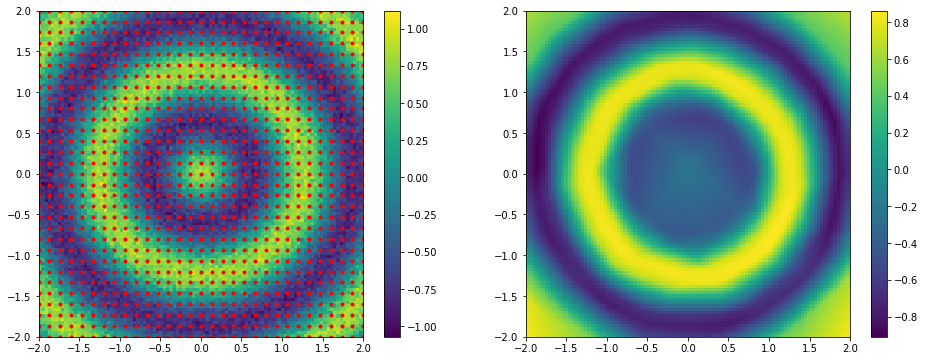

In [147]:
# plot the results from the standard neural net
n1=100
x_test1,x_test2=np.meshgrid(np.linspace(-2,2,n1),np.linspace(-2,2,n1))
x_test_2d=np.hstack([x_test1.reshape((n1*n1,1)),x_test2.reshape(n1*n1,1)])
y_test_net_2d=nnet.forward(x_test_2d).reshape((n1,n1))
# print(y_test_net_2d.shape)
# y_test_2d= 0.8*np.sin(x_test_2d[:,0]*3.4)+0.8*np.sin(x_test_2d[:,1]*3)#+np.random.randn(x.shape[0],1)*0.1
y_test_2d=test_fun_2d(x_test_2d)
y_test_2d=y_test_2d.reshape((n1,n1))
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.pcolor(x_test1,x_test2,y_test_2d);
plt.colorbar()
plt.plot(x[:,0],x[:,1],'r.')
plt.subplot(1,2,2)
plt.pcolor(x_test1,x_test2,y_test_net_2d);
plt.colorbar()
# plt.plot(x[:,0],x[:,1],'r.')


In [189]:
import torchvision
import torch
import pickle


In [190]:
mnist_data=torchvision.datasets.MNIST('.',transform=torchvision.transforms.ToTensor())

In [191]:
def one_hot(x, class_count):
    
    vec1=np.zeros((1,class_count))
    vec1[0,x]=1
    return vec1


In [197]:
mnist_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: ToTensor()

In [414]:
n_data=1001
# hidden_layers=[16,32,256,32,16]
hidden_layers=[16,16,16,16]
hidden_layers=[128,128,128]
hidden_layers=[32,256,256,32]
hidden_layers=[256,256,256,256,32]
hidden_layers=[512,256,128,62]


n1=int(np.sqrt(n_data))
x1,x2=np.meshgrid(np.linspace(-2,2,n1),np.linspace(-2,2,n1))
x=np.hstack([x1.reshape((n1*n1,1)),x2.reshape(n1*n1,1)])
# x=np.random.rand(n_data,2)*4-2
# y= 0.8*np.sin(x[:,0]*3.4)+0.8*np.sin(x[:,1]*3)#+np.random.randn(x.shape[0],1)*0.1
# y=y.reshape((y.shape[0],1))
y=test_fun_2d(x)
x_test=np.linspace(-2,2,1000).reshape(1000,1)
# plt.plot(x,y,'.')
net=BNet7(hidden_layer_sizes=hidden_layers,input_dim=784,output_dim=10,lambda_initaliser=lambda_initaliser,initialiser_function=initialiser_function)
save_nets=[]
n_data=1000
xx=np.zeros((n_data,784))
yy=np.zeros((n_data,10))
for ii in range(50): #for observations in the dataset
    print(ii)
    for jj in range(n_data):
        X_i=np.array(mnist_data[ii*n_data+jj][0]).reshape(1,784)#mnist_data[ii][0].flatten()
        Y_i=one_hot(mnist_data[ii*n_data+jj][1],10)
        xx[jj,:]=X_i
        yy[jj,:]=Y_i
    net.train(xx,yy,print_error=False,passes=1,total_info=1,failed_attempts=10)
    save_nets.append(copy.deepcopy(net))

0
1
2
3
4


KeyboardInterrupt: 

In [446]:
hidden_layer_options=[[512,256,128,64],[512,521,256,128,64],[512,512,512,256,128,64],
                      [256],[256,256],[256,256,256],[256,256,256,256],[256,256,256,256,256],[256,256,256,256,256,256]]
file_num=0
for hidden_layers in hidden_layer_options:
    net=BNet7(hidden_layer_sizes=hidden_layers,input_dim=784,output_dim=10,lambda_initaliser=lambda_initaliser,initialiser_function=initialiser_function)
    save_nets=[]
    n_data=1000
    xx=np.zeros((n_data,784))
    yy=np.zeros((n_data,10))
    for ii in range(50): #for observations in the dataset
        print(ii)
        for jj in range(n_data):
            X_i=np.array(mnist_data[ii*n_data+jj][0]).reshape(1,784)#mnist_data[ii][0].flatten()
            Y_i=one_hot(mnist_data[ii*n_data+jj][1],10)
            xx[jj,:]=X_i
            yy[jj,:]=Y_i
        net.train(xx,yy,print_error=False,passes=1,total_info=1,failed_attempts=10)
        save_nets.append(copy.deepcopy(net))
    
    with open('net_save'+str(file_num)+'.pkl','wb') as output:
        pickle.dump((hidden_layers,save_nets),output,pickle.HIGHEST_PROTOCOL)
#         pickle.dump(hidden_layers,output,pickle.HIGHEST_PROTOCOL)
    file_num+=1    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9


In [398]:
correct=[]
totals=np.zeros(10)
totals_correct=np.zeros(10)
for ii in range(5000):
    ind=50000+ii
    X_i=np.array(mnist_data[ind][0]).reshape(1,784)#mnist_data[ii][0].flatten()
    Y_i=one_hot(mnist_data[ind][1],10)
    Y_out=net.forward(X_i)[0]
    print('Truth: ' + str(np.argmax(Y_i))+ ', Predicted: '+str(np.argmax(Y_out)))
    totals[np.argmax(Y_i)]+=1

    if np.argmax(Y_i)==np.argmax(Y_out):
        correct.append(1)
        totals_correct[np.argmax(Y_i)]+=1
    else:
        correct.append(0)
print(sum(correct))

Truth: 3, Predicted: 4
Truth: 8, Predicted: 8
Truth: 6, Predicted: 6
Truth: 9, Predicted: 7
Truth: 6, Predicted: 2
Truth: 4, Predicted: 9
Truth: 5, Predicted: 1
Truth: 3, Predicted: 7
Truth: 8, Predicted: 8
Truth: 4, Predicted: 9
Truth: 5, Predicted: 2
Truth: 2, Predicted: 1
Truth: 3, Predicted: 3
Truth: 8, Predicted: 8
Truth: 4, Predicted: 9
Truth: 8, Predicted: 2
Truth: 1, Predicted: 1
Truth: 5, Predicted: 2
Truth: 0, Predicted: 0
Truth: 5, Predicted: 3
Truth: 9, Predicted: 9
Truth: 7, Predicted: 7
Truth: 4, Predicted: 3
Truth: 1, Predicted: 1
Truth: 0, Predicted: 0
Truth: 3, Predicted: 7
Truth: 0, Predicted: 2
Truth: 6, Predicted: 6
Truth: 2, Predicted: 3
Truth: 9, Predicted: 0
Truth: 9, Predicted: 7
Truth: 4, Predicted: 1
Truth: 1, Predicted: 1
Truth: 3, Predicted: 3
Truth: 6, Predicted: 0
Truth: 8, Predicted: 2
Truth: 0, Predicted: 0
Truth: 7, Predicted: 7
Truth: 7, Predicted: 7
Truth: 6, Predicted: 4
Truth: 8, Predicted: 3
Truth: 9, Predicted: 9
Truth: 0, Predicted: 0
Truth: 3, P

Truth: 3, Predicted: 3
Truth: 7, Predicted: 6
Truth: 5, Predicted: 9
Truth: 1, Predicted: 1
Truth: 2, Predicted: 2
Truth: 3, Predicted: 2
Truth: 7, Predicted: 4
Truth: 7, Predicted: 9
Truth: 3, Predicted: 1
Truth: 9, Predicted: 7
Truth: 3, Predicted: 9
Truth: 7, Predicted: 7
Truth: 7, Predicted: 7
Truth: 4, Predicted: 4
Truth: 3, Predicted: 9
Truth: 0, Predicted: 0
Truth: 7, Predicted: 7
Truth: 2, Predicted: 2
Truth: 7, Predicted: 7
Truth: 5, Predicted: 1
Truth: 9, Predicted: 9
Truth: 0, Predicted: 6
Truth: 9, Predicted: 9
Truth: 6, Predicted: 6
Truth: 4, Predicted: 4
Truth: 4, Predicted: 4
Truth: 0, Predicted: 0
Truth: 9, Predicted: 3
Truth: 7, Predicted: 7
Truth: 8, Predicted: 9
Truth: 8, Predicted: 8
Truth: 5, Predicted: 2
Truth: 1, Predicted: 2
Truth: 1, Predicted: 1
Truth: 5, Predicted: 5
Truth: 5, Predicted: 2
Truth: 1, Predicted: 1
Truth: 3, Predicted: 7
Truth: 6, Predicted: 1
Truth: 3, Predicted: 9
Truth: 1, Predicted: 1
Truth: 4, Predicted: 1
Truth: 5, Predicted: 5
Truth: 0, P

Truth: 3, Predicted: 9
Truth: 2, Predicted: 2
Truth: 4, Predicted: 9
Truth: 9, Predicted: 3
Truth: 5, Predicted: 9
Truth: 7, Predicted: 7
Truth: 6, Predicted: 6
Truth: 8, Predicted: 5
Truth: 7, Predicted: 7
Truth: 5, Predicted: 7
Truth: 8, Predicted: 6
Truth: 5, Predicted: 2
Truth: 9, Predicted: 9
Truth: 5, Predicted: 3
Truth: 0, Predicted: 0
Truth: 3, Predicted: 3
Truth: 1, Predicted: 1
Truth: 1, Predicted: 1
Truth: 2, Predicted: 2
Truth: 0, Predicted: 0
Truth: 3, Predicted: 9
Truth: 6, Predicted: 6
Truth: 4, Predicted: 9
Truth: 5, Predicted: 3
Truth: 5, Predicted: 7
Truth: 6, Predicted: 4
Truth: 6, Predicted: 4
Truth: 5, Predicted: 0
Truth: 7, Predicted: 7
Truth: 9, Predicted: 6
Truth: 8, Predicted: 3
Truth: 5, Predicted: 2
Truth: 9, Predicted: 8
Truth: 1, Predicted: 1
Truth: 1, Predicted: 5
Truth: 8, Predicted: 8
Truth: 8, Predicted: 0
Truth: 7, Predicted: 7
Truth: 6, Predicted: 6
Truth: 7, Predicted: 7
Truth: 7, Predicted: 7
Truth: 7, Predicted: 7
Truth: 1, Predicted: 2
Truth: 9, P

Truth: 9, Predicted: 9
Truth: 5, Predicted: 2
Truth: 4, Predicted: 9
Truth: 7, Predicted: 7
Truth: 0, Predicted: 0
Truth: 8, Predicted: 1
Truth: 1, Predicted: 1
Truth: 5, Predicted: 5
Truth: 2, Predicted: 1
Truth: 9, Predicted: 7
Truth: 3, Predicted: 7
Truth: 8, Predicted: 2
Truth: 4, Predicted: 4
Truth: 1, Predicted: 1
Truth: 5, Predicted: 2
Truth: 7, Predicted: 7
Truth: 6, Predicted: 0
Truth: 9, Predicted: 9
Truth: 7, Predicted: 7
Truth: 3, Predicted: 5
Truth: 8, Predicted: 0
Truth: 5, Predicted: 6
Truth: 9, Predicted: 9
Truth: 4, Predicted: 4
Truth: 0, Predicted: 0
Truth: 0, Predicted: 0
Truth: 1, Predicted: 8
Truth: 0, Predicted: 0
Truth: 2, Predicted: 2
Truth: 6, Predicted: 4
Truth: 3, Predicted: 4
Truth: 3, Predicted: 9
Truth: 4, Predicted: 4
Truth: 9, Predicted: 0
Truth: 5, Predicted: 1
Truth: 8, Predicted: 4
Truth: 6, Predicted: 3
Truth: 8, Predicted: 3
Truth: 7, Predicted: 7
Truth: 7, Predicted: 3
Truth: 8, Predicted: 5
Truth: 8, Predicted: 9
Truth: 9, Predicted: 8
Truth: 7, P

Truth: 5, Predicted: 0
Truth: 5, Predicted: 3
Truth: 7, Predicted: 7
Truth: 6, Predicted: 6
Truth: 5, Predicted: 8
Truth: 0, Predicted: 0
Truth: 7, Predicted: 7
Truth: 8, Predicted: 2
Truth: 7, Predicted: 7
Truth: 5, Predicted: 3
Truth: 8, Predicted: 8
Truth: 0, Predicted: 0
Truth: 2, Predicted: 2
Truth: 6, Predicted: 0
Truth: 6, Predicted: 1
Truth: 1, Predicted: 1
Truth: 8, Predicted: 1
Truth: 5, Predicted: 5
Truth: 9, Predicted: 7
Truth: 8, Predicted: 8
Truth: 6, Predicted: 6
Truth: 4, Predicted: 1
Truth: 9, Predicted: 9
Truth: 2, Predicted: 2
Truth: 6, Predicted: 6
Truth: 3, Predicted: 3
Truth: 0, Predicted: 0
Truth: 9, Predicted: 9
Truth: 3, Predicted: 7
Truth: 7, Predicted: 7
Truth: 5, Predicted: 5
Truth: 6, Predicted: 4
Truth: 7, Predicted: 9
Truth: 9, Predicted: 9
Truth: 6, Predicted: 6
Truth: 1, Predicted: 1
Truth: 2, Predicted: 4
Truth: 9, Predicted: 4
Truth: 7, Predicted: 7
Truth: 0, Predicted: 0
Truth: 3, Predicted: 7
Truth: 6, Predicted: 0
Truth: 3, Predicted: 2
Truth: 7, P

Truth: 1, Predicted: 1
Truth: 1, Predicted: 4
Truth: 4, Predicted: 3
Truth: 3, Predicted: 0
Truth: 8, Predicted: 6
Truth: 1, Predicted: 1
Truth: 8, Predicted: 2
Truth: 8, Predicted: 2
Truth: 1, Predicted: 1
Truth: 3, Predicted: 5
Truth: 9, Predicted: 7
Truth: 7, Predicted: 7
Truth: 6, Predicted: 6
Truth: 9, Predicted: 1
Truth: 7, Predicted: 1
Truth: 3, Predicted: 7
Truth: 7, Predicted: 7
Truth: 0, Predicted: 0
Truth: 3, Predicted: 3
Truth: 9, Predicted: 9
Truth: 6, Predicted: 6
Truth: 4, Predicted: 9
Truth: 2, Predicted: 2
Truth: 4, Predicted: 9
Truth: 6, Predicted: 9
Truth: 0, Predicted: 0
Truth: 4, Predicted: 3
Truth: 7, Predicted: 7
Truth: 5, Predicted: 3
Truth: 4, Predicted: 3
Truth: 9, Predicted: 9
Truth: 2, Predicted: 9
Truth: 1, Predicted: 1
Truth: 8, Predicted: 8
Truth: 3, Predicted: 3
Truth: 7, Predicted: 7
Truth: 1, Predicted: 1
Truth: 2, Predicted: 5
Truth: 9, Predicted: 9
Truth: 4, Predicted: 2
Truth: 3, Predicted: 3
Truth: 7, Predicted: 4
Truth: 9, Predicted: 9
Truth: 8, P

Truth: 6, Predicted: 8
Truth: 8, Predicted: 8
Truth: 5, Predicted: 9
Truth: 8, Predicted: 9
Truth: 9, Predicted: 6
Truth: 3, Predicted: 7
Truth: 0, Predicted: 0
Truth: 0, Predicted: 9
Truth: 8, Predicted: 9
Truth: 1, Predicted: 1
Truth: 8, Predicted: 5
Truth: 4, Predicted: 6
Truth: 0, Predicted: 7
Truth: 5, Predicted: 9
Truth: 8, Predicted: 3
Truth: 6, Predicted: 6
Truth: 3, Predicted: 3
Truth: 4, Predicted: 4
Truth: 3, Predicted: 3
Truth: 7, Predicted: 7
Truth: 7, Predicted: 7
Truth: 8, Predicted: 5
Truth: 9, Predicted: 9
Truth: 0, Predicted: 0
Truth: 8, Predicted: 4
Truth: 3, Predicted: 3
Truth: 4, Predicted: 4
Truth: 1, Predicted: 1
Truth: 5, Predicted: 5
Truth: 9, Predicted: 7
Truth: 0, Predicted: 0
Truth: 0, Predicted: 0
Truth: 5, Predicted: 0
Truth: 9, Predicted: 9
Truth: 2, Predicted: 2
Truth: 1, Predicted: 1
Truth: 0, Predicted: 0
Truth: 2, Predicted: 2
Truth: 0, Predicted: 9
Truth: 7, Predicted: 7
Truth: 7, Predicted: 7
Truth: 0, Predicted: 0
Truth: 9, Predicted: 7
Truth: 1, P

Truth: 1, Predicted: 1
Truth: 0, Predicted: 0
Truth: 2, Predicted: 6
Truth: 1, Predicted: 1
Truth: 4, Predicted: 4
Truth: 2, Predicted: 7
Truth: 2, Predicted: 3
Truth: 3, Predicted: 5
Truth: 8, Predicted: 7
Truth: 4, Predicted: 4
Truth: 3, Predicted: 4
Truth: 5, Predicted: 3
Truth: 7, Predicted: 4
Truth: 6, Predicted: 2
Truth: 1, Predicted: 1
Truth: 7, Predicted: 9
Truth: 7, Predicted: 7
Truth: 8, Predicted: 6
Truth: 9, Predicted: 6
Truth: 0, Predicted: 7
Truth: 6, Predicted: 6
Truth: 1, Predicted: 0
Truth: 3, Predicted: 3
Truth: 2, Predicted: 2
Truth: 6, Predicted: 1
Truth: 3, Predicted: 9
Truth: 7, Predicted: 7
Truth: 4, Predicted: 6
Truth: 4, Predicted: 4
Truth: 5, Predicted: 8
Truth: 2, Predicted: 2
Truth: 6, Predicted: 6
Truth: 5, Predicted: 3
Truth: 7, Predicted: 2
Truth: 6, Predicted: 2
Truth: 8, Predicted: 9
Truth: 3, Predicted: 3
Truth: 0, Predicted: 6
Truth: 3, Predicted: 3
Truth: 1, Predicted: 1
Truth: 2, Predicted: 5
Truth: 2, Predicted: 7
Truth: 0, Predicted: 0
Truth: 3, P

Truth: 3, Predicted: 9
Truth: 8, Predicted: 5
Truth: 3, Predicted: 3
Truth: 0, Predicted: 0
Truth: 3, Predicted: 3
Truth: 1, Predicted: 1
Truth: 1, Predicted: 1
Truth: 3, Predicted: 7
Truth: 8, Predicted: 0
Truth: 9, Predicted: 2
Truth: 9, Predicted: 4
Truth: 5, Predicted: 9
Truth: 6, Predicted: 6
Truth: 3, Predicted: 3
Truth: 1, Predicted: 1
Truth: 5, Predicted: 9
Truth: 0, Predicted: 0
Truth: 4, Predicted: 9
Truth: 5, Predicted: 9
Truth: 5, Predicted: 2
Truth: 9, Predicted: 9
Truth: 2, Predicted: 1
Truth: 6, Predicted: 4
Truth: 1, Predicted: 1
Truth: 9, Predicted: 9
Truth: 7, Predicted: 7
Truth: 8, Predicted: 9
Truth: 4, Predicted: 5
Truth: 5, Predicted: 6
Truth: 8, Predicted: 5
Truth: 8, Predicted: 8
Truth: 7, Predicted: 7
Truth: 5, Predicted: 9
Truth: 6, Predicted: 0
Truth: 5, Predicted: 5
Truth: 9, Predicted: 4
Truth: 8, Predicted: 8
Truth: 2, Predicted: 3
Truth: 0, Predicted: 0
Truth: 7, Predicted: 7
Truth: 3, Predicted: 3
Truth: 2, Predicted: 7
Truth: 0, Predicted: 0
Truth: 4, P

Truth: 1, Predicted: 6
Truth: 1, Predicted: 1
Truth: 0, Predicted: 0
Truth: 5, Predicted: 7
Truth: 1, Predicted: 1
Truth: 6, Predicted: 0
Truth: 2, Predicted: 0
Truth: 3, Predicted: 2
Truth: 3, Predicted: 3
Truth: 4, Predicted: 4
Truth: 4, Predicted: 4
Truth: 7, Predicted: 2
Truth: 5, Predicted: 9
Truth: 3, Predicted: 3
Truth: 6, Predicted: 6
Truth: 3, Predicted: 1
Truth: 7, Predicted: 7
Truth: 1, Predicted: 9
Truth: 8, Predicted: 3
Truth: 8, Predicted: 8
Truth: 0, Predicted: 0
Truth: 3, Predicted: 1
Truth: 1, Predicted: 1
Truth: 7, Predicted: 3
Truth: 2, Predicted: 4
Truth: 4, Predicted: 9
Truth: 3, Predicted: 3
Truth: 2, Predicted: 2
Truth: 4, Predicted: 2
Truth: 9, Predicted: 7
Truth: 5, Predicted: 7
Truth: 1, Predicted: 1
Truth: 6, Predicted: 1
Truth: 2, Predicted: 1
Truth: 7, Predicted: 3
Truth: 0, Predicted: 0
Truth: 0, Predicted: 6
Truth: 2, Predicted: 9
Truth: 9, Predicted: 3
Truth: 8, Predicted: 0
Truth: 5, Predicted: 3
Truth: 8, Predicted: 9
Truth: 0, Predicted: 2
Truth: 7, P

Truth: 0, Predicted: 0
Truth: 0, Predicted: 0
Truth: 9, Predicted: 0
Truth: 4, Predicted: 9
Truth: 2, Predicted: 1
Truth: 8, Predicted: 2
Truth: 7, Predicted: 7
Truth: 1, Predicted: 1
Truth: 4, Predicted: 8
Truth: 3, Predicted: 3
Truth: 2, Predicted: 7
Truth: 1, Predicted: 1
Truth: 6, Predicted: 4
Truth: 0, Predicted: 0
Truth: 0, Predicted: 3
Truth: 9, Predicted: 9
Truth: 1, Predicted: 1
Truth: 0, Predicted: 0
Truth: 4, Predicted: 4
Truth: 1, Predicted: 1
Truth: 6, Predicted: 9
Truth: 2, Predicted: 2
Truth: 4, Predicted: 7
Truth: 3, Predicted: 5
Truth: 1, Predicted: 1
Truth: 4, Predicted: 4
Truth: 8, Predicted: 2
Truth: 5, Predicted: 6
Truth: 1, Predicted: 1
Truth: 6, Predicted: 0
Truth: 2, Predicted: 6
Truth: 7, Predicted: 4
Truth: 4, Predicted: 2
Truth: 8, Predicted: 9
Truth: 4, Predicted: 1
Truth: 9, Predicted: 9
Truth: 0, Predicted: 0
Truth: 0, Predicted: 0
Truth: 6, Predicted: 7
Truth: 1, Predicted: 3
Truth: 5, Predicted: 5
Truth: 2, Predicted: 1
Truth: 5, Predicted: 3
Truth: 3, P

Truth: 5, Predicted: 3
Truth: 0, Predicted: 0
Truth: 3, Predicted: 9
Truth: 2, Predicted: 2
Truth: 1, Predicted: 1
Truth: 4, Predicted: 4
Truth: 8, Predicted: 9
Truth: 3, Predicted: 3
Truth: 2, Predicted: 8
Truth: 6, Predicted: 6
Truth: 2, Predicted: 5
Truth: 9, Predicted: 9
Truth: 3, Predicted: 3
Truth: 5, Predicted: 5
Truth: 0, Predicted: 6
Truth: 3, Predicted: 3
Truth: 2, Predicted: 2
Truth: 2, Predicted: 4
Truth: 9, Predicted: 9
Truth: 8, Predicted: 4
Truth: 4, Predicted: 9
Truth: 1, Predicted: 1
Truth: 9, Predicted: 9
Truth: 9, Predicted: 4
Truth: 0, Predicted: 0
Truth: 2, Predicted: 2
Truth: 2, Predicted: 2
Truth: 6, Predicted: 7
Truth: 7, Predicted: 2
Truth: 2, Predicted: 2
Truth: 4, Predicted: 7
Truth: 0, Predicted: 0
Truth: 9, Predicted: 9
Truth: 3, Predicted: 3
Truth: 9, Predicted: 9
Truth: 4, Predicted: 3
Truth: 2, Predicted: 1
Truth: 2, Predicted: 2
Truth: 8, Predicted: 3
Truth: 0, Predicted: 0
Truth: 1, Predicted: 1
Truth: 2, Predicted: 7
Truth: 5, Predicted: 3
Truth: 6, P

Truth: 9, Predicted: 9
Truth: 2, Predicted: 4
Truth: 7, Predicted: 3
Truth: 2, Predicted: 2
Truth: 1, Predicted: 1
Truth: 8, Predicted: 3
Truth: 0, Predicted: 0
Truth: 4, Predicted: 3
Truth: 9, Predicted: 9
Truth: 7, Predicted: 7
Truth: 0, Predicted: 0
Truth: 0, Predicted: 0
Truth: 7, Predicted: 7
Truth: 1, Predicted: 1
Truth: 1, Predicted: 1
Truth: 3, Predicted: 7
Truth: 7, Predicted: 7
Truth: 7, Predicted: 7
Truth: 3, Predicted: 3
Truth: 9, Predicted: 9
Truth: 6, Predicted: 6
Truth: 3, Predicted: 3
Truth: 8, Predicted: 7
Truth: 9, Predicted: 1
Truth: 0, Predicted: 6
Truth: 3, Predicted: 9
Truth: 8, Predicted: 7
Truth: 3, Predicted: 3
Truth: 3, Predicted: 3
Truth: 1, Predicted: 1
Truth: 2, Predicted: 7
Truth: 4, Predicted: 4
Truth: 0, Predicted: 6
Truth: 8, Predicted: 2
Truth: 9, Predicted: 9
Truth: 2, Predicted: 1
Truth: 0, Predicted: 0
Truth: 1, Predicted: 1
Truth: 6, Predicted: 6
Truth: 4, Predicted: 8
Truth: 1, Predicted: 1
Truth: 1, Predicted: 1
Truth: 7, Predicted: 7
Truth: 3, P

In [415]:

correct_fracton=[]

for net1 in save_nets:
    print(net1)
    correct=[]
    totals=np.zeros(10)
    totals_correct=np.zeros(10)
    n_test=5000
#     correct_fracton=[]
    for ii in range(n_test):
        ind=50000+ii
        X_i=np.array(mnist_data[ind][0]).reshape(1,784)#mnist_data[ii][0].flatten()
        Y_i=one_hot(mnist_data[ind][1],10)
        Y_out=net1.forward(X_i)[0]
#         print('Truth: ' + str(np.argmax(Y_i))+ ', Predicted: '+str(np.argmax(Y_out)))
        totals[np.argmax(Y_i)]+=1

        if np.argmax(Y_i)==np.argmax(Y_out):
            correct.append(1)
            totals_correct[np.argmax(Y_i)]+=1
        else:
            correct.append(0)
    print(sum(correct)/n_test)
    print(totals)
    print(totals_correct)
    print(totals_correct/totals)
    correct_fracton.append(sum(correct)/n_test)
    print('=====')

0.6254
[502. 534. 497. 521. 484. 457. 485. 527. 515. 478.]
[413. 488. 259. 302. 363. 180. 353. 370. 227. 172.]
[0.82270916 0.91385768 0.52112676 0.57965451 0.75       0.39387309
 0.72783505 0.70208729 0.4407767  0.35983264]
=====
0.6642
[502. 534. 497. 521. 484. 457. 485. 527. 515. 478.]
[423. 498. 276. 317. 365. 185. 398. 387. 267. 205.]
[0.84262948 0.93258427 0.55533199 0.6084453  0.75413223 0.404814
 0.82061856 0.73434535 0.5184466  0.42887029]
=====
0.6848
[502. 534. 497. 521. 484. 457. 485. 527. 515. 478.]
[441. 508. 292. 331. 375. 202. 411. 387. 286. 191.]
[0.87848606 0.95131086 0.58752515 0.6353167  0.77479339 0.44201313
 0.84742268 0.73434535 0.55533981 0.39958159]
=====
0.6954
[502. 534. 497. 521. 484. 457. 485. 527. 515. 478.]
[442. 506. 287. 332. 388. 189. 422. 393. 318. 200.]
[0.88047809 0.94756554 0.57746479 0.63723608 0.80165289 0.41356674
 0.87010309 0.74573055 0.61747573 0.41841004]
=====


In [394]:
save_nets

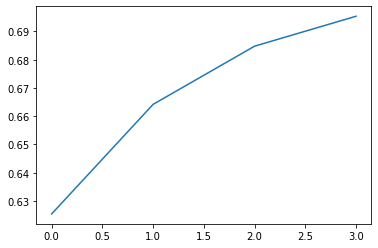

In [416]:
plt.plot(correct_fracton)

In [220]:
print(totals)
print(totals_correct)
print(totals_correct/totals)

[502. 534. 497. 521. 484. 457. 485. 527. 515. 478.]
[341. 510. 196. 269. 324. 106. 367. 300. 331. 101.]
[0.67928287 0.95505618 0.3943662  0.51631478 0.66942149 0.23194748
 0.75670103 0.56925996 0.64271845 0.21129707]


In [223]:
Y_out,Y_i

(array([[ 0.63155847,  0.17934295, -0.21901222,  0.36938726, -0.0520595 ,
          0.28347194, -0.14613476, -0.03787791, -0.10506128,  0.09631389]]),
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

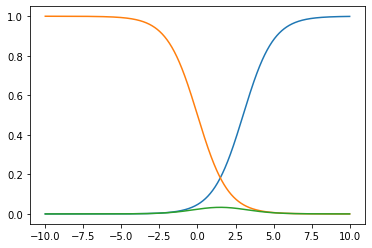

In [234]:
xx=np.linspace(-10,10,1001)
y1=1/(1+np.exp(-xx+3))
y2=1/(1+np.exp(xx))
plt.plot(xx,y1)
plt.plot(xx,y2)
plt.plot(xx,y1*y2)